In [423]:
import pandas as pd
import re
import string
from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
import spacy
import random
from nltk.stem import PorterStemmer
import random
import time
import faiss
from nltk.stem import SnowballStemmer
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import iqr
pd.options.display.float_format = '{:,.4f}'.format
tqdm.pandas()

nlp = spacy.load("en_core_web_sm")
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\annap\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\annap\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\annap\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [424]:
SnowballStemmer.languages

('arabic',
 'danish',
 'dutch',
 'english',
 'finnish',
 'french',
 'german',
 'hungarian',
 'italian',
 'norwegian',
 'porter',
 'portuguese',
 'romanian',
 'russian',
 'spanish',
 'swedish')

# Read  Files

In [425]:
fn_files = ['cf74', 'cf75', 'cf76', 'cf77', 'cf78', 'cf79']
fn_queries = 'cfquery'

## Document

In [426]:
def extract_informations(filename):

    data = {}
    id_actual = None
    information = ""

    try:
        with open(filename, "r", encoding='ansi') as file:
            for line in file:
                if line.startswith("RN"): # É o ID
                    # Se há uma informação anterior, armazena no dicionário
                    if id_actual and information:
                        data[id_actual] = information
                        information = ""

                    # Obtém o ID a partir da segunda palavra
                    id_actual = line.split()[1]
                elif line.startswith(("TI", "MJ", "MN", "AB", "EX")) and id_actual:
                    information += line[3:].strip()
                    while True:
                        next_line = file.readline()
                        if not next_line or re.match(r'\b[A-Z]{2}\s', next_line):
                            break
                        information += " " + next_line.strip()

            # Adiciona a última informação ao dicionário
            if id_actual and information:
                data[id_actual] = information

    except FileNotFoundError:
        print("File not founded.")

    return data


data_complete = {}

# Extract information each file
for fn in fn_files:
    path_file = f"../data/{fn}"
    data = extract_informations(path_file)

    data_complete.update(data)

df_data = pd.DataFrame(list(data_complete.items()), columns=['id', 'TEXT']).rename(columns={'id':'id_document'})
df_data = df_data.astype({'id_document': int})
df_data.head()

,id_document,TEXT
0,1,Pseudomonas aeruginosa infection in cystic fib...
1,2,Amylase content of mixed saliva in children.SA...
2,3,A clinical study of the diagnosis of cystic fi...
3,4,A methodological study of the diagnosis of cys...
4,5,Proteolytic activity in duodenal juice in infa...


## Query

In [427]:
def read_file_query(file_path):
 
    data = {'QN': [], 'QU': [], 'NR': [], 'RD': []}

    qn_id = None
    qu_texto = None
    nr_numero = None
    rd_lista = []

    with open(file_path, 'r') as arquivo:
        for linha in arquivo:
            if linha.startswith('RD'):
                rd_lista = [int(x) for x in re.findall(r'\d+', linha)]
                while True:
                    try:
                        proxima_linha = next(arquivo)
                        if proxima_linha.startswith('QN'):
                            # Save acumulated
                            if qn_id is not None:
                                data['QN'].append(qn_id)
                                data['QU'].append(qu_texto)
                                data['NR'].append(nr_numero)
                                data['RD'].append(rd_lista)

                            # Restart variables to next "QN"
                            qn_id = int(re.search(r'\d+', proxima_linha).group())
                            qu_texto = None
                            nr_numero = None
                            rd_lista = []
                            break
                        rd_lista.extend([int(x) for x in re.findall(r'\d+', proxima_linha)])
                    except StopIteration:
                        break
            elif linha.startswith('QN'):
                qn_id = int(re.search(r'\d+', linha).group())
            elif linha.startswith('QU'):
                qu_texto = linha[3:].strip()
            elif linha.startswith('NR'):
                nr_numero = int(re.search(r'\d+', linha).group())

    
    if qn_id is not None:
        data['QN'].append(qn_id)
        data['QU'].append(qu_texto)
        data['NR'].append(nr_numero)
        data['RD'].append(rd_lista)

    df = pd.DataFrame(data)
    df["RD"] = df["RD"].apply(lambda x: x[::2])
    df["len(RD)"] = df["RD"].apply(lambda x: len(x))
    
    return df

# Lê o arquivo e cria o DataFrame
df_query = read_file_query(f'../data/{fn_queries}')
df_query = df_query.rename(columns={'QN':'id_query'}).astype({'id_query': int})
df_query.head()

,id_query,QU,NR,RD,len(RD)
0,1,What are the effects of calcium on the physica...,34,"[139, 151, 166, 311, 370, 392, 439, 440, 441, ...",34
1,2,Can one distinguish between the effects of muc...,7,"[169, 434, 454, 498, 499, 592, 875]",7
2,3,How are salivary glycoproteins from CF patient...,43,"[23, 40, 139, 190, 221, 246, 309, 311, 325, 34...",43
3,4,What is the lipid composition of CF respirator...,9,"[503, 538, 539, 540, 553, 604, 669, 711, 876]",9
4,5,Is CF mucus abnormal?,131,"[23, 47, 50, 60, 114, 132, 135, 139, 151, 169,...",131


In [428]:
assert len(df_query[df_query['NR'] != df_query['len(RD)']]) == 0, "There is a problem to load data."

In [429]:
df_query = df_query.drop(columns='len(RD)')

# Text preprocessing

In [430]:
pp_config = { 'convert': 'lower', # lower or upper 
              'reduce': 'lemming', # stemming or lemming  lemming
              'stop_words': True,  # remove if true else ~remove
              'punctuation':True, # remove if true, else ~remove
              'number': True,
             }

def lemmatize_text_spacy(text):
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc])

def stem_text(text):
    stemmer = PorterStemmer()
    return ' '.join([stemmer.stem(word) for word in word_tokenize(text)])

def remove_stopwords_from_text(text):
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

def remove_punctuation_nltk(text):
    
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    tokens = word_tokenize(text)
    tokens_without_punctuation = [word for word in tokens if word not in string.punctuation]
    
    return ' '.join(tokens_without_punctuation)

def remove_number(text):
    return ' '.join(re.sub(r'\w*\d\w*', '', word) for word in word_tokenize(text))

def preprocess_english_text(text, conf:dict, n_exemple:int):
    
    pp_stats = {}

    if conf['convert'] == 'lower':
        print(f"Before lower ex.: {text[n_exemple].split('.')[0]}")
        text = text.str.lower()
        pp_count_words = list(map(lambda string: len(string.split()), text))
        pp_stats['lower'] = pp_count_words
        print(f"-> After lower ex.:  {text[n_exemple].split('.')[0]}")

    if conf['convert'] == 'upper':
        print(f"Before upper ex.: {text[n_exemple].split('.')[0]}")
        text = text.str.upper()
        pp_count_words = list(map(lambda string: len(string.split()), text))
        pp_stats['upper'] = pp_count_words
        print(f"-> After upper ex.:  {text[n_exemple].split('.')[0]}")

    if conf['reduce'] == 'lemming':
        print(f"Before lemmatizer ex.: {text[n_exemple].split('.')[0]}")
        processed = text.apply(lemmatize_text_spacy)
        pp_count_words = list(map(lambda string: len(string.split()), text))
        pp_stats['reduce'] = pp_count_words
        print(f"-> After lemmatizer ex.: {processed[n_exemple].split('.')[0]}")

    if conf['reduce'] == 'steamming':
        print(f"Before stemming ex.: {text.iloc[n_exemple].split('.')[0]}")
        processed = text.apply(stem_text)
        pp_count_words = processed.apply(lambda x: len(x.split()))
        pp_stats['reduce'] = pp_count_words
        print(f"-> After stemming ex.: {processed.iloc[n_exemple].split('.')[0]}")

    if conf['stop_words'] == True:        
        print(f"Before stopword ex.: {processed[n_exemple].split('.')[0]}")
        processed = processed.apply(remove_stopwords_from_text)
        pp_count_words = processed.apply(lambda x: len(x.split()))
        pp_stats['stop_words'] = pp_count_words
        print(f"-> After stopword ex.: {processed.iloc[n_exemple].split('.')[0]}")

    if conf['punctuation'] == True:
        print(f"Before remove punctuation ex.:  {processed[n_exemple].split('.')[0]}")
        processed = processed.apply(remove_punctuation_nltk)
        pp_count_words = processed.apply(lambda x: len(x.split()))
        pp_stats['punctuation'] = pp_count_words
        print(f"-> After remove ponctuation ex.: {processed.iloc[n_exemple].split('.')[0]}")
    
    if conf['number'] == True:

        print(f"Before remove numbers ex.:  {processed[n_exemple].split('.')[0]}")
        processed = [remove_number(text) for text in processed]
        pp_count_words = [len(text.split()) for text in processed]
        pp_stats['number'] = pp_count_words
        print(f"-> After remove numbers ex.: {processed[n_exemple].split('.')[0]}")

    return processed, pp_stats

def contabilize_stats(data, stats)->pd.DataFrame:

    data['lower_len'] = stats['lower']
    data['reduce_len'] = stats['reduce']
    data['stop_len'] = stats['stop_words']
    data['punc_len'] = stats['punctuation']
    data['num_len'] = stats['number']

    return data

In [431]:
print(f"{'-'*50}Data: Document{'-'*50}")
df_data_pp = df_data.copy()
df_data_pp['pp'], pp_count_d= preprocess_english_text(df_data['TEXT'], pp_config, n_exemple=0)

print(f"{'-'*50}Data: Queries{'-'*50}")
df_query_pp = df_query.copy()
df_query_pp['pp'], pp_count_q= preprocess_english_text(df_query['QU'], pp_config, n_exemple=0)

--------------------------------------------------Data: Document--------------------------------------------------
Before lower ex.: Pseudomonas aeruginosa infection in cystic fibrosis
-> After lower ex.:  pseudomonas aeruginosa infection in cystic fibrosis
Before lemmatizer ex.: pseudomonas aeruginosa infection in cystic fibrosis
-> After lemmatizer ex.: pseudomonas aeruginosa infection in cystic fibrosis 
Before stopword ex.: pseudomonas aeruginosa infection in cystic fibrosis 
-> After stopword ex.: pseudomonas aeruginosa infection cystic fibrosis 
Before remove punctuation ex.:  pseudomonas aeruginosa infection cystic fibrosis 
-> After remove ponctuation ex.: pseudomonas aeruginosa infection cystic fibrosis occurrence precipitate antibody pseudomonas aeruginosa relation concentration sixteen serum protein clinical radiographical status lungscystic fibrosis co pseudomonas aeruginosa m pseudomona infection co respiratory tract infection cothe significance pseudomonas aeruginosa infe

In [432]:
df_data_pp = contabilize_stats(df_data_pp, pp_count_d)
df_query_pp = contabilize_stats(df_query_pp, pp_count_q)

df_data_pp.head()

,id_document,TEXT,pp,lower_len,reduce_len,stop_len,punc_len,num_len
0,1,Pseudomonas aeruginosa infection in cystic fib...,pseudomonas aeruginosa infection cystic fibros...,207,207,155,130,124
1,2,Amylase content of mixed saliva in children.SA...,amylase content mixed saliva childrensaliva en...,152,152,120,103,98
2,3,A clinical study of the diagnosis of cystic fi...,clinical study diagnosis cystic fibrosis instr...,157,157,115,94,90
3,4,A methodological study of the diagnosis of cys...,methodological study diagnosis cystic fibrosis...,203,203,136,111,111
4,5,Proteolytic activity in duodenal juice in infa...,proteolytic activity duodenal juice infant chi...,129,129,124,92,85


## Preprocessing reduced by synonyms

In [433]:
def get_vocabulary(data_text, query_text):
    
    data_complete = data_text.to_list()
    data_complete.extend(query_text.to_list())

    words = []

    for phrase in data_complete:
        for word in phrase.split():
            words.append(word)

    return set(words)

def get_synonyms(word):

    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonyms.add(lemma.name())
    return list(synonyms)

def choose_reference_synonym(synonyms):
    return random.choice(synonyms) if synonyms else None

def replace_synonyms_in_text(text, synonyms_dict):

    if isinstance(text, str):
        words = text.split()
        replaced_words = [synonyms_dict.get(word, word) for word in words]
        return ' '.join(replaced_words)
    else:
        return text

def reduce_vocabulary(data, query, col_text):
 
    vocabulary = get_vocabulary(data[col_text], query[col_text])
    print("Len vocabulary initial:", len(vocabulary))
    
    synonyms_uniques = {}  

    for word in vocabulary:
        synonyms = get_synonyms(word)
        word_reference = choose_reference_synonym(synonyms)
        if word_reference:
            for synonym in synonyms:
                synonyms_uniques[synonym] = word_reference

    print(f"Before synonyms ex.: {data.loc[0, col_text]}")

    r_data = data.copy()
    r_query = query.copy()
    r_data['syn_pp'] = data[col_text].apply(lambda text: replace_synonyms_in_text(text, synonyms_uniques))
    r_query['syn_pp'] = query[col_text].apply(lambda text: replace_synonyms_in_text(text, synonyms_uniques))

    print(f"After synonyms ex.: {data.loc[0, col_text]}")
    vocabulary = get_vocabulary(r_data['syn_pp'], r_query['syn_pp'])
    print("Len vocabulary final:", len(vocabulary))
   
    return r_data, r_query

In [434]:
df_data_pp, df_query_pp = reduce_vocabulary(df_data_pp, df_query_pp, 'pp')

df_data_pp['syn_len'] = df_data_pp['syn_pp'].apply(lambda x: len(x.split()))
df_query_pp['syn_len'] = df_query_pp['syn_pp'].apply(lambda x: len(x.split()))

df_data_pp.head()

Len vocabulary initial: 9308
Before synonyms ex.: pseudomonas aeruginosa infection cystic fibrosis occurrence precipitate antibody pseudomonas aeruginosa relation concentration sixteen serum protein clinical radiographical status lungscystic fibrosis co pseudomonas aeruginosa m pseudomona infection co respiratory tract infection cothe significance pseudomonas aeruginosa infection respiratory tract  cystic fibrosis patient study mean immunoelectrophoretical analysis patient sera number precipitin pseudomonas aeruginosa concentration  serum protein addition clinical radiographical status lung evaluate use  scoring system precipitin pseudomonas aeruginosa demonstrate sera maximum number one serum  concentration  serum protein significantly change compare match control person notably igg iga elevate acute phase protein change latter suggest active tissue damage concentration  acute phase protein notably haptoglobin correlate number precipitin suggest respiratory tract infection patient man

,id_document,TEXT,pp,lower_len,reduce_len,stop_len,punc_len,num_len,syn_pp,syn_len
0,1,Pseudomonas aeruginosa infection in cystic fib...,pseudomonas aeruginosa infection cystic fibros...,207,207,155,130,124,pseudomonas aeruginosa contagion cystic fibros...,124
1,2,Amylase content of mixed saliva in children.SA...,amylase content mixed saliva childrensaliva en...,152,152,120,103,98,amylase capability flux saliva childrensaliva ...,98
2,3,A clinical study of the diagnosis of cystic fi...,clinical study diagnosis cystic fibrosis instr...,157,157,115,94,90,clinical canvas diagnosis cystic fibrosis impl...,90
3,4,A methodological study of the diagnosis of cys...,methodological study diagnosis cystic fibrosis...,203,203,136,111,111,methodological canvas diagnosis cystic fibrosi...,111
4,5,Proteolytic activity in duodenal juice in infa...,proteolytic activity duodenal juice infant chi...,129,129,124,92,85,proteolytic bodily_function duodenal juice cod...,85


# Vectorizing

## TF-IDF

In [435]:
def tf_idf_technicals(data_documents, data_queries, type:str):

    initial_time = time.time()
    
    if type == 'tf':
        vectorizer = TfidfVectorizer(use_idf=False, norm='l1') 
    elif type == 'idf':
        vectorizer = TfidfVectorizer(use_idf=True, smooth_idf=False, norm='l2')  
    elif type == 'tf-idf':
        vectorizer = TfidfVectorizer()

    document_matrix = vectorizer.fit_transform(data_documents)
    query_vector = vectorizer.transform(data_queries)

    words = vectorizer.get_feature_names_out()

    df_vector_documents = pd.DataFrame(data=document_matrix.toarray(), columns=words)
    df_vector_queries = pd.DataFrame(data=query_vector.toarray(), columns=words)

    print(f"Execution time: {time.time() - initial_time}s\nSize:{len(words)}")
    return df_vector_documents, df_vector_queries

In [436]:
# fazer um sem a resução de vocabulário, e outro com a redução, para ver o que vai dar depis 
df_v_document, df_v_query =  tf_idf_technicals(df_data_pp['pp'], df_query_pp['pp'], 'tf-idf')
df_v_document.head()

Execution time: 0.19379758834838867s
Size:9283


,aa,aathe,aathis,ab,abalthough,aban,abandon,abdoman,abdomen,abdominal,...,zealand,zellweger,zero,zeta,zinc,zona,zone,zymogen,zymogram,zz
0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
3,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
4,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


## Sentence Transform (Embeddings)

In [437]:
model_name= 'paraphrase-MiniLM-L6-v2'

def get_embeddings(model_name:str, data):
    
    initial_time = time.time()
    
    model = SentenceTransformer(model_name)
    sentence_embeddings = model.encode(data)

    print(f"Execution time: {time.time() - initial_time}s\nSize:{len(sentence_embeddings)}")
    return sentence_embeddings

print("Embeddings Documents")
e_document = get_embeddings(model_name, df_data_pp['pp'])

print("Embeddings Queries")
e_query= get_embeddings(model_name, df_query_pp['pp'])

Embeddings Documents
Execution time: 49.857011795043945s
Size:1239
Embeddings Queries
Execution time: 0.7169482707977295s
Size:100


# FAISS

In [438]:
document_ids = df_data_pp['id_document'].to_list()
query_ids =  df_query_pp['id_query'].to_list()

## Query Exploration Data Analysis

In [439]:
df_query = df_query.rename(columns={'NR':'qnt_doc_relevant', 'RD':'doc_relevant'})
df_query.head()

,id_query,QU,qnt_doc_relevant,doc_relevant
0,1,What are the effects of calcium on the physica...,34,"[139, 151, 166, 311, 370, 392, 439, 440, 441, ..."
1,2,Can one distinguish between the effects of muc...,7,"[169, 434, 454, 498, 499, 592, 875]"
2,3,How are salivary glycoproteins from CF patient...,43,"[23, 40, 139, 190, 221, 246, 309, 311, 325, 34..."
3,4,What is the lipid composition of CF respirator...,9,"[503, 538, 539, 540, 553, 604, 669, 711, 876]"
4,5,Is CF mucus abnormal?,131,"[23, 47, 50, 60, 114, 132, 135, 139, 151, 169,..."


In [443]:
df_query['qnt_doc_relevant'].describe()

count   100.0000
mean     48.1900
std      49.9755
min       2.0000
25%      17.0000
50%      32.0000
75%      55.5000
max     304.0000
Name: qnt_doc_relevant, dtype: float64

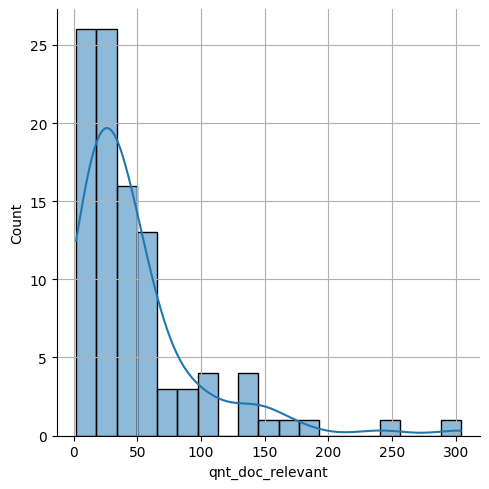

In [444]:
sns.displot(df_query['qnt_doc_relevant'], kde=True)
plt.grid(True)
plt.show()

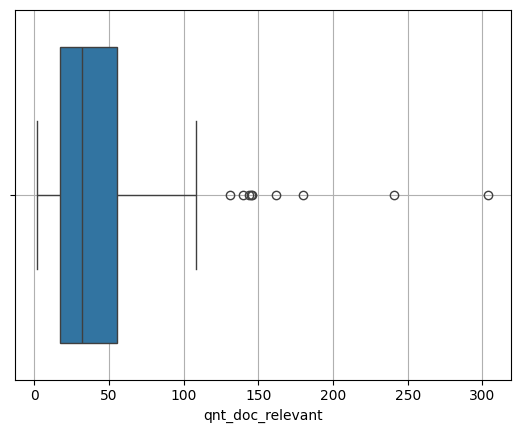

In [445]:
sns.boxplot(x=df_query['qnt_doc_relevant'])
plt.grid(True)
plt.show()

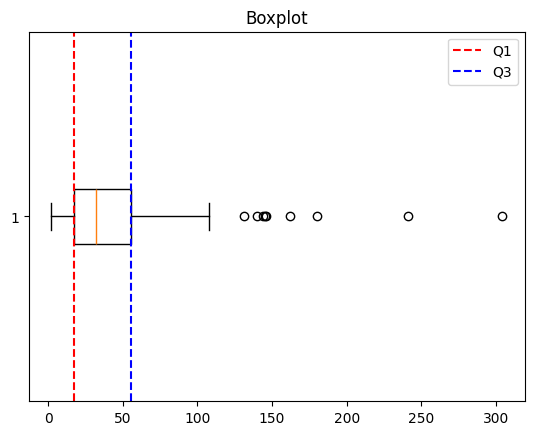

Q1: 17.0
Q3: 55.5
IQR:38.5


In [446]:
# Criar o gráfico de boxplot
plt.boxplot(df_query['qnt_doc_relevant'], vert=False)

# Calcular os quartis e o IQR
q1 = np.percentile(df_query['qnt_doc_relevant'], 25)
q3 = np.percentile(df_query['qnt_doc_relevant'], 75)
iqr = q3 - q1

plt.axvline(q1, color='r', linestyle='--', label='Q1')
plt.axvline(q3, color='b', linestyle='--', label='Q3')
plt.legend()
plt.title('Boxplot')
plt.show()

print(f"Q1: {q1}\nQ3: {q3}\nIQR:{iqr}")

Como escolher um k mínimo para retorno no FAISS? 

A média de documentos não pode ser considerada boa bara este tipo de base de dados, onde possui muitos outilers com valores muito alto, isso faz com que a dispersão dos dados seja alta.

Entretanto se escolhemos como limite o Q1, estaremos concentrando os resultados apenas em 25% dos dados, se esolhermos o valor de corte como Q3 satisfazemos o nível de consulta para 75% da base. Entretanto ao escolher o ponto de corte em Q1, ignoramos a representatividade de 50% dos dados, o que levaria a uma falsa precisão do sistema. Caso escolha Q3, estariamos negligenciando 25% da base de dados, buscando além do que é necessário e consequentemente trazendo lixo para os resultados.

O IQR é um número que fica entre o Q1 e o Q3, que consegue equilibrar o trade-off para o sistema entre deixar de retornar muito documento relevante e retornar irrerlevantes quando não seria necessário um grande retorno. Enteão, de acordo com a análise dessa base de dados, o mais indicado é retornar o número mínimo de 38 documentos(IQR), pois é o número que representa melhor a quantidade de documentos relevantes para cada registro no conjunto de dados completo.

# FAISS

IndexFlatIP é o que utiliza a similaridade do cosseno.

In [329]:
# type_index = FlatIP or IVFFlat
def apply_FAISS(document, d_ids, query, q_ids, type_index:str, K):
    
    initial_time = time.time()
    
    dim =  document.shape[1] 
    nb = len(document) 
    nq = len(query) 
    nlist = len(query)
    document = np.asarray(document, dtype='float32')
    query = np.asarray(query, dtype='float32')

    if type_index == 'FlatIP':
        
        index = faiss.IndexFlatIP(dim)   
        index = faiss.IndexIDMap(index)

    if type_index == 'FlatIVFF':

        # normalize the input
        document = document / np.linalg.norm( document, axis=1, keepdims=True)
        query = query / np.linalg.norm( query, axis=1, keepdims=True) 

        # Criar o índice IVFFlat para métrica do cosseno
        quantizer = faiss.IndexFlatIP(dim)  # Usamos o IndexFlatIP como quantizador
        index = faiss.IndexIVFFlat(quantizer, document.shape[1], nlist, faiss.METRIC_INNER_PRODUCT)

        index.train(document)
    
    index.add_with_ids(document, document_ids)
    
    # o I vai ser o id dos documentos recuperados
    D, I = index.search(query, K)     

    # Criar uma lista para armazenar as informações
    result = []
    # Iterar sobre os pontos de consulta e seus neighbors mais próximos
    for i, q_id in zip(range(len(I)), query_ids):
        
        neighbors = I[i]
        dist_neighbors = D[i]
        result.append({ 'id_query': q_id,
                        'doc_retrieval': neighbors,
                        'dist': dist_neighbors})
    print(f"Execution Time = {time.time() - initial_time}")
    return pd.DataFrame(result)

## TF-IDF

In [447]:
# Vector TF-IDF
# FlatIP ou IVFFlat
print("FAISS FlatIP TF-IDF:")
result_v = apply_FAISS(df_v_document, document_ids, df_v_query, query_ids, 'FlatIP', 10)
#print("FAISS FlatIVFF TF-IDF:")
#result_v_IVFF = apply_FAISS(df_v_document, document_ids, df_v_query, query_ids, 'FlatIVFF', 10)
#result_v = pd.merge( result_v, result_v_IVFF, on='id_query', suffixes=('_IP', '_IVFF'))
result_v.head()

FAISS FlatIP TF-IDF:
Execution Time = 0.0687253475189209


,id_query,doc_retrieval,dist
0,1,"[484, 437, 499, 741, 498, 827, 957, 592, 533, ...","[0.2589415, 0.25389516, 0.23026434, 0.2285017,..."
1,2,"[592, 498, 980, 754, 481, 499, 925, 114, 711, ...","[0.42752358, 0.20987636, 0.1886766, 0.17549495..."
2,3,"[856, 633, 439, 959, 500, 1206, 23, 77, 805, 1...","[0.4266391, 0.39230436, 0.3165515, 0.29545963,..."
3,4,"[715, 604, 357, 876, 725, 1030, 928, 662, 1039...","[0.40107936, 0.3433038, 0.29039, 0.2810194, 0...."
4,5,"[498, 754, 499, 711, 592, 265, 975, 151, 501, ...","[0.35646084, 0.33025038, 0.3027913, 0.29837427..."


### Embeddings

In [448]:
# Embeddings
# FlatIP ou IeFFlat
print("FAISS FlatIP Embeddings:")
result_e = apply_FAISS(e_document, document_ids, e_query, query_ids, 'FlatIP', 10)
#print("FAISS FlatIVFF Embeddings:")
#result_e_IVFFF = apply_FAISS(e_document, document_ids, e_query, query_ids, 'FlatIVFF', 10)
#result_e = pd.merge( result_e, result_e_IVFFF, on='id_query', suffixes=('_IP', '_IVFF'))
result_e.head()

FAISS FlatIP Embeddings:
Execution Time = 0.006983041763305664


,id_query,doc_retrieval,dist
0,1,"[827, 461, 960, 533, 741, 454, 437, 975, 484, ...","[19.028828, 19.018747, 17.614992, 16.262873, 1..."
1,2,"[975, 437, 805, 151, 265, 980, 498, 439, 461, ...","[16.072195, 15.253544, 14.646388, 14.53042, 14..."
2,3,"[439, 633, 805, 445, 1125, 950, 1175, 256, 374...","[17.994047, 16.580603, 16.448719, 16.26377, 15..."
3,4,"[604, 876, 669, 278, 374, 347, 439, 441, 924, ...","[19.566305, 18.690874, 16.48114, 16.212358, 16..."
4,5,"[501, 867, 975, 498, 439, 437, 685, 1019, 875,...","[22.765892, 22.241232, 21.325352, 20.742886, 2..."


# Evaluation

In [450]:
result_e = pd.merge(result_e, df_query[['id_query','qnt_doc_relevant', 'doc_relevant']], on='id_query')
result_v = pd.merge(result_v, df_query[['id_query','qnt_doc_relevant', 'doc_relevant']], on='id_query')
result_v.head(2)

,id_query,doc_retrieval,dist,qnt_doc_relevant,doc_relevant
0,1,"[484, 437, 499, 741, 498, 827, 957, 592, 533, ...","[0.2589415, 0.25389516, 0.23026434, 0.2285017,...",34,"[139, 151, 166, 311, 370, 392, 439, 440, 441, ..."
1,2,"[592, 498, 980, 754, 481, 499, 925, 114, 711, ...","[0.42752358, 0.20987636, 0.1886766, 0.17549495...",7,"[169, 434, 454, 498, 499, 592, 875]"


## Precision and Recall

In [458]:
def calculate_precision_recall_complete(data):
    
    precision_recall_list = []

    for row in data.iterrows():

        id_query = row[1]['id_query']
        qnt_doc_relevant = row[1]['qnt_doc_relevant']
        doc_relevant = set(row[1]['doc_relevant'])
        doc_retrieval = set(row[1]['doc_retrieval'])

        precision = len(doc_relevant.intersection(doc_retrieval)) / len(doc_retrieval) if len(doc_retrieval) > 0 else 0
 
        recall = len(doc_relevant.intersection(doc_retrieval)) / qnt_doc_relevant

        precision_recall_list.append({
            'id_query': id_query,
            'precision_general': precision,
            'recall_general': recall,
            'doc_retrieval': list(doc_retrieval)
        })

    return pd.DataFrame( precision_recall_list)

def calculate_precision_recall_by_level(df: pd.DataFrame) -> pd.DataFrame:
    
    result = []

    for _, row in df.iterrows():
        id_query = row['id_query']
        total_retrieval = row['doc_retrieval']

        # Itera pelos níveis especificados
        for level in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
            # Calcula a quantidade de elementos a serem considerados
            qnt_elements = int(len(total_retrieval) * level)
            doc_retrieval_it = total_retrieval[:qnt_elements]

            # Documentos relevantes na iteração atual
            doc_relevant_it = set(row['doc_relevant'][:qnt_elements])

            # Cálculo da interseção entre documentos recuperados e relevantes
            intersection = set(doc_retrieval_it).intersection(set(row['doc_relevant']))

            # Cálculo da precisão (precision) e recall
            precision = len(intersection) / len(doc_retrieval_it) if len(doc_retrieval_it) > 0 else 0
            recall = len(intersection) / len(doc_relevant_it) if len(doc_relevant_it) > 0 else 0

            result.append({
                'id_query': id_query,
                'percent_retrieval': level * 100,
                'precision': f"{precision:.2f}",
                'recall': f"{recall:.2f}",
                'doc_retrieval': doc_retrieval_it
            })

    return pd.DataFrame(result)

In [460]:
pr_complete_e = calculate_precision_recall_complete(result_e)
pr_complete_v = calculate_precision_recall_complete(result_v)
pr_complete_e.head()

,id_query,precision_general,recall_general,doc_retrieval
0,1,0.4000,0.1176,"[960, 484, 741, 454, 967, 461, 975, 533, 437, ..."
1,2,0.1000,0.1429,"[439, 481, 805, 265, 461, 975, 498, 980, 437, ..."
2,3,0.5000,0.1163,"[256, 644, 1125, 805, 950, 439, 1175, 633, 374..."
3,4,0.4000,0.4444,"[439, 711, 924, 876, 374, 278, 441, 347, 604, ..."
4,5,0.8000,0.0611,"[867, 1125, 875, 685, 975, 498, 501, 437, 439,..."


In [465]:
pr_complete_e['precision_general'] = pd.to_numeric(pr_complete_e['precision_general'])
pr_complete_e['recall_general'] = pd.to_numeric(pr_complete_e['recall_general'])
pr_complete_v['precision_general'] = pd.to_numeric(pr_complete_v['precision_general'])
pr_complete_v['recall_general'] = pd.to_numeric(pr_complete_v['recall_general'])

In [461]:
# ver o que é o p@5 e o p@10 e calculá-los
pr_level_e = calculate_precision_recall_by_level(result_e)
pr_level_v = calculate_precision_recall_by_level(result_v)
pr_level_v.head()

,id_query,percent_retrieval,precision,recall,doc_retrieval
0,1,10.0000,0.00,0.00,[484]
1,1,20.0000,0.00,0.00,"[484, 437]"
2,1,30.0000,0.00,0.00,"[484, 437, 499]"
3,1,40.0000,0.00,0.00,"[484, 437, 499, 741]"
4,1,50.0000,0.00,0.00,"[484, 437, 499, 741, 498]"


In [467]:
pr_level_e['precision'] = pd.to_numeric(pr_level_e['precision'])
pr_level_e['recall'] = pd.to_numeric(pr_level_e['recall'])
pr_level_v['precision'] = pd.to_numeric(pr_level_v['precision'])
pr_level_v['recall'] = pd.to_numeric(pr_level_v['recall'])

## MRR(Q) Sh=5

In [370]:
# Calculate the position of first document retrieval, to calculate mmr
def find_first_position(relevant, retrieval):

    for i, element in enumerate(retrieval):
        if element in relevant:
            return i  # Retorna a posição onde o element foi encontrado em l2

    return -1  # Retorna None se nenhum element de l2 estiver em l1

def calculate_rr(scorrect, sh):
    if scorrect <= sh:
        return 1
    else:
        return 0

def calculate_mrr(data, threshold):  
          
    total_mrr = 0.0
    num_queries = len(data)

    for row in data.iterrows() :
        scorrect = row[1]['first_position']
        rr = calculate_rr(scorrect, threshold)
        total_mrr += rr

    mrr = total_mrr / num_queries
    
    return mrr

In [463]:
# Encontrar a posição
result_e['first_position'] = result_e.apply(lambda row: find_first_position(row['doc_relevant'], row['doc_retrieval']), axis=1)
result_v['first_position'] = result_v.apply(lambda row: find_first_position(row['doc_relevant'], row['doc_retrieval']), axis=1)
result_v.head()

,id_query,doc_retrieval,dist,qnt_doc_relevant,doc_relevant,first_position
0,1,"[484, 437, 499, 741, 498, 827, 957, 592, 533, ...","[0.2589415, 0.25389516, 0.23026434, 0.2285017,...",34,"[139, 151, 166, 311, 370, 392, 439, 440, 441, ...",5
1,2,"[592, 498, 980, 754, 481, 499, 925, 114, 711, ...","[0.42752358, 0.20987636, 0.1886766, 0.17549495...",7,"[169, 434, 454, 498, 499, 592, 875]",0
2,3,"[856, 633, 439, 959, 500, 1206, 23, 77, 805, 1...","[0.4266391, 0.39230436, 0.3165515, 0.29545963,...",43,"[23, 40, 139, 190, 221, 246, 309, 311, 325, 34...",0
3,4,"[715, 604, 357, 876, 725, 1030, 928, 662, 1039...","[0.40107936, 0.3433038, 0.29039, 0.2810194, 0....",9,"[503, 538, 539, 540, 553, 604, 669, 711, 876]",1
4,5,"[498, 754, 499, 711, 592, 265, 975, 151, 501, ...","[0.35646084, 0.33025038, 0.3027913, 0.29837427...",131,"[23, 47, 50, 60, 114, 132, 135, 139, 151, 169,...",0


In [372]:
mrr_e = calculate_mrr(result_e, 5)
mrr_v = calculate_mrr(result_v, 5)
print(f"Mrr(Q)\nEmbedings {mrr_e}\nVectorize {mrr_v}")

Mrr(Q)
Embedings 0.91
Vectorize 0.97


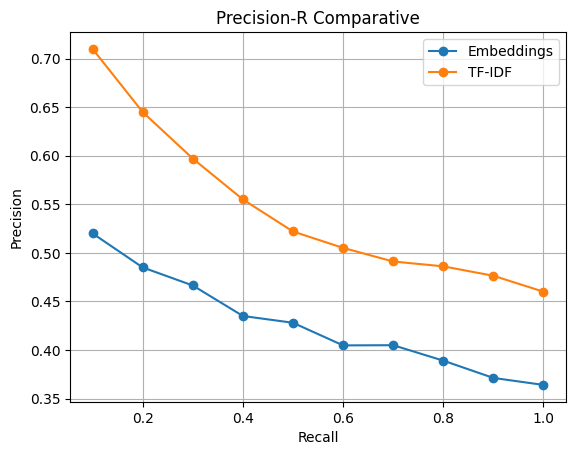

In [468]:
graph_e = pr_level_e.groupby(by="percent_retrieval")[['precision', 'recall']].mean()
graph_v = pr_level_v.groupby(by="percent_retrieval")[['precision', 'recall']].mean()
# Criar o gráfico de linhas
#plt.figure(figsize=(10, 6))
plt.plot(graph_e.index/100, graph_e['precision'], marker='o', linestyle='-', label='Embeddings')
# Linha para o segundo DataFrame
plt.plot(graph_v.index/100, graph_v['precision'], marker='o', linestyle='-', label='TF-IDF')

# Adicionar rótulos e título
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-R Comparative')

# Exibir o gráfico
plt.legend()
plt.grid(True)
plt.show()

## Histograma 20 primeiras pesquisas

In [469]:
aux_bar_e = pr_level_e.query("id_query <= 20 ")
aux_bar_v = pr_level_v.query("id_query <= 20 ")

In [470]:
x = aux_bar_e.groupby("id_query")['precision'].mean().reset_index()
y = aux_bar_v.groupby("id_query")['precision'].mean().reset_index()

In [471]:
r_precision = x['precision'] - y['precision']
r_precision = r_precision.reset_index()
r_precision = r_precision.astype({'index':str})

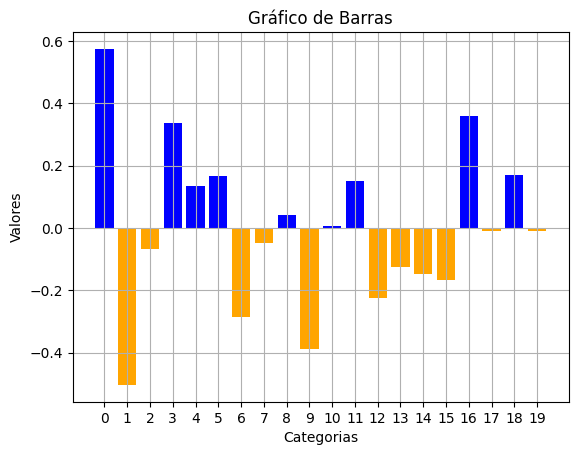

In [473]:
colors = ['orange' if val < 0 else 'blue' for val in r_precision['precision']]

plt.bar(x=r_precision['index'], height=r_precision['precision'], color=colors)
# Adicionar rótulos e título
plt.grid(True)
plt.xlabel('Categorias')
plt.ylabel('Valores')
plt.title('Gráfico de Barras')

# Exibir o gráfico
plt.show()

Precisão (Precision): A proporção dos documentos recuperados que são relevantes.
Revocação (Recall): A proporção dos documentos relevantes que foram recuperados.
P@5 (Precision at 5): A precisão considerando apenas os primeiros 5 documentos recuperados.
P@10 (Precision at 10): A precisão considerando apenas os primeiros 10 documentos recuperados.
### Se é para recuperar o p@10, no mínimo tem que vir 10 documentos na pesquisa :)

In [475]:
result_e.head()

,id_query,doc_retrieval,dist,qnt_doc_relevant,doc_relevant,first_position
0,1,"[827, 461, 960, 533, 741, 454, 437, 975, 484, ...","[19.028828, 19.018747, 17.614992, 16.262873, 1...",34,"[139, 151, 166, 311, 370, 392, 439, 440, 441, ...",0
1,2,"[975, 437, 805, 151, 265, 980, 498, 439, 461, ...","[16.072195, 15.253544, 14.646388, 14.53042, 14...",7,"[169, 434, 454, 498, 499, 592, 875]",6
2,3,"[439, 633, 805, 445, 1125, 950, 1175, 256, 374...","[17.994047, 16.580603, 16.448719, 16.26377, 15...",43,"[23, 40, 139, 190, 221, 246, 309, 311, 325, 34...",0
3,4,"[604, 876, 669, 278, 374, 347, 439, 441, 924, ...","[19.566305, 18.690874, 16.48114, 16.212358, 16...",9,"[503, 538, 539, 540, 553, 604, 669, 711, 876]",0
4,5,"[501, 867, 975, 498, 439, 437, 685, 1019, 875,...","[22.765892, 22.241232, 21.325352, 20.742886, 2...",131,"[23, 47, 50, 60, 114, 132, 135, 139, 151, 169,...",0


In [478]:
def precision_at_k(relevant_docs, retrieved_docs, k):
    """
    Calcula a Precisão em k (P@k).

    Parâmetros:
    relevant_docs (list): Lista de IDs de documentos relevantes.
    retrieved_docs (list): Lista de IDs de documentos recuperados.
    k (int): Número de documentos considerados para o cálculo.

    Retorna:
    float: Precisão em k (P@k).
    """
    # Considera apenas os primeiros k documentos recuperados
    retrieved_docs_at_k = retrieved_docs[:k]

    # Calcula a interseção entre documentos relevantes e recuperados até k
    intersection = set(relevant_docs).intersection(set(retrieved_docs_at_k))

    # Calcula a precisão em k
    precision = len(intersection) / k if k > 0 else 0

    return precision

# Parâmetro para o valor de k (por exemplo, k=5 para P@5)
k = 5
result_e[f'P@{k}'] = result_e.apply(lambda row: precision_at_k( row['doc_relevant'] , row['doc_retrieval'], k), axis=1)
result_v[f'P@{k}'] = result_v.apply(lambda row: precision_at_k( row['doc_relevant'] , row['doc_retrieval'], k), axis=1)
k = 10
result_e[f'P@{k}'] = result_e.apply(lambda row: precision_at_k( row['doc_relevant'] , row['doc_retrieval'], k), axis=1)
result_v[f'P@{k}'] = result_v.apply(lambda row: precision_at_k( row['doc_relevant'] , row['doc_retrieval'], k), axis=1)